# Example: Measuring T1

T1 is an experiment that measures the relaxation time of a qubit.

Information stored in a qubit decays exponentially. The time constant of the decay is called the relaxation time $T_1$.

The experiment measures $T_1$ by preparing selected qubits in the  excited state by playing an X gate,
waiting some time, and measuring the qubit.
The waiting time is swept to reveal the exponential decay of the excited state probability.

## Preparing the circuit

In [1]:
import os
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from iqm.qiskit_iqm import IQMProvider
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import qiskit_to_pulla

In [2]:
cocos_url = os.environ['PULLA_COCOS_URL']                     # or set the URL directly here
station_control_url = os.environ['PULLA_STATION_CONTROL_URL'] # or set the URL directly here

p = Pulla(station_control_url)
compiler = p.get_standard_compiler()

provider = IQMProvider(cocos_url)
backend = provider.get_backend()

[11-26 14:16:58;W] station-control-client version '1.23' is newer minor version than '1.18' used by the station control server, some new client features might not be supported.


Prepare the circuit with X gates for each of the qubits you want to test

In [3]:
import numpy as np

# Preparing the circuit
qc = QuantumCircuit(3)
qc.rx(np.pi, [0, 1, 2])
qc.measure_all()

qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)
circuits, compiler = qiskit_to_pulla(p, backend, qc_optimized)

context = compiler.compiler_context()
data = circuits

In order to add arbitrary Wait instructions in to our circuit we can manipulate the Timeboxes between the stages 4 and 5.
We define a function that copies the circuit we defined above and adds Wait instructions to the end of the circuit.

In [4]:
from iqm.cpc.compiler.compiler import CompilationStage

sweep_times = np.linspace(0, 100e-6, 41)


def generate_t1(timeboxes, context):
    """Generate multiple versions of the input circuit, where a Wait of increasing duration is inserted before measurement."""

    circuit_timebox = timeboxes[0]  # assumes only one input circuit
    modified_timeboxes = []
    for wait_time in sweep_times:
        wait_box = context["builder"].wait(circuit_timebox.locus_components, wait_time)
        # insert a wait between everything else and the final measurement
        c = circuit_timebox[:-1] + wait_box + circuit_timebox[-1]
        modified_timeboxes.append(c)

    context["circuit_metrics"] = context["circuit_metrics"] * len(sweep_times)  # Keep metadata in sync
    return modified_timeboxes, context

Now let's inject our function from above between stages 3 and 4, right before the timeboxes are converted to schedules. Since we changed the amount of circuits, we must also multiply the number of circuit metrics.

In addition, we change the measurement mode to `circuit`, so that only the selected qubits are measured. The measurement mode is part of the `CircuitExecutionOptions`, the the standard compiler constructed by Pulla comes with default options. To make changes, we replace the whole object with a new instance of `CircuitExecutionOptions`:

In [5]:
from iqm.cpc.interface.compiler import (
    CircuitBoundaryMode,
    CircuitExecutionOptions,
    DDMode,
    HeraldingMode,
    MeasurementMode,
    MoveGateFrameTrackingMode,
    MoveGateValidationMode,
)

compiler.options = CircuitExecutionOptions(
    measurement_mode=MeasurementMode.CIRCUIT,  # here we changed `ALL` to `CIRCUIT`
    heralding_mode=HeraldingMode.NONE,
    dd_mode=DDMode.DISABLED,
    dd_strategy=None,
    circuit_boundary_mode=CircuitBoundaryMode.ALL,
    move_gate_frame_tracking=MoveGateFrameTrackingMode.FULL,
    move_gate_validation=MoveGateValidationMode.STRICT,
    active_reset_cycles=None
)

In [6]:
add_waits = CompilationStage(name="add_waits")
add_waits.add_passes(generate_t1)

compiler.stages.insert(3, add_waits)

In [7]:
playlist, context = compiler.compile(data)

Since we are working with an experiment where averaging of the results can be useful, we can set `settings.options.averaging_bins` to 1. By default it is the same value as number of shots but if set to 1 then the backend will average the results in to one bin. By doing this we don't need to later on average the results.


In [8]:
settings, context = compiler.build_settings(context, shots=1000)
settings.options.averaging_bins = 1
settings.options

SettingNode{'end_delay': Setting(parameter=Parameter(name='options.end_delay', label='Delay from end of sequence to next trigger', unit='s', data_type=<DataType.NUMBER: 1>, collection_type=<CollectionType.SCALAR: 0>, element_indices=None, _parent_name=None, _parent_label=None), value=0.0003), 'averaging_bins': Setting(parameter=Parameter(name='options.averaging_bins', label='Average the repeats into this many bins', unit='', data_type=<DataType.NUMBER: 1>, collection_type=<CollectionType.SCALAR: 0>, element_indices=None, _parent_name=None, _parent_label=None), value=1), 'playlist_repeats': Setting(parameter=Parameter(name='options.playlist_repeats', label='Number of times to repeat execution of corresponding playlist', unit='', data_type=<DataType.NUMBER: 1>, collection_type=<CollectionType.SCALAR: 0>, element_indices=None, _parent_name=None, _parent_label=None), value=1000)}

## Executing the modified circuit

After inspecting the settings tree and the final playlist we are ready to execute the playlist.

In [9]:
res = p.execute(playlist, context, settings)

[11-26 14:17:02;I] Submitted sweep with ID: f954824d-66de-4c65-a438-cfc20f897d5e
[11-26 14:17:02;I] Created task in queue with ID: b1d7683d-7c2d-4781-b619-0f33ffde81bc
[11-26 14:17:02;I] Sweep link: http://xld11-s2.xld11.iqm.fi/station/sweeps/f954824d-66de-4c65-a438-cfc20f897d5e
[11-26 14:17:02;I] Task link: http://xld11-s2.xld11.iqm.fi/station/tasks/b1d7683d-7c2d-4781-b619-0f33ffde81bc
[11-26 14:17:02;I] Waiting for the sweep to finish...
[11-26 14:17:20;I] Sweep status: SweepStatus.SUCCESS
[11-26 14:17:20;I] [{'meas_3_0_2': [[0.9769999980926514], [0.8379999995231628], [0.7300000190734863], [0.6620000004768372], [0.5899999737739563], [0.5260000228881836], [0.4970000088214874], [0.43700000643730164], [0.3959999978542328], [0.33899998664855957], [0.3089999854564667], [0.3179999887943268], [0.2750000059604645], [0.2669999897480011], [0.2409999966621399], [0.23600000143051147], [0.21699999272823334], [0.18000000715255737], [0.19200000166893005], [0.1550000011920929], [0.15700000524520874]

## Visualising the results

After the circuit has executed succesfully we can visualise our results.

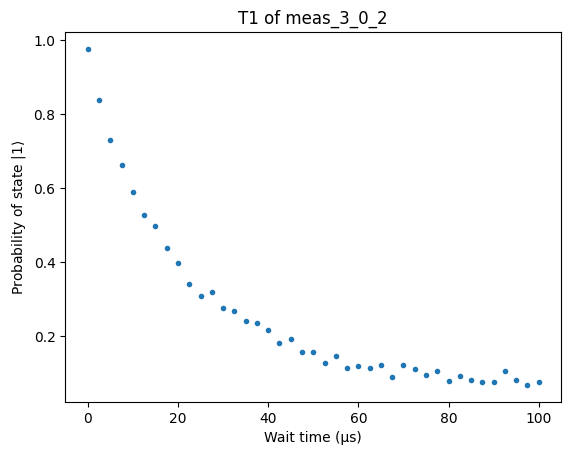

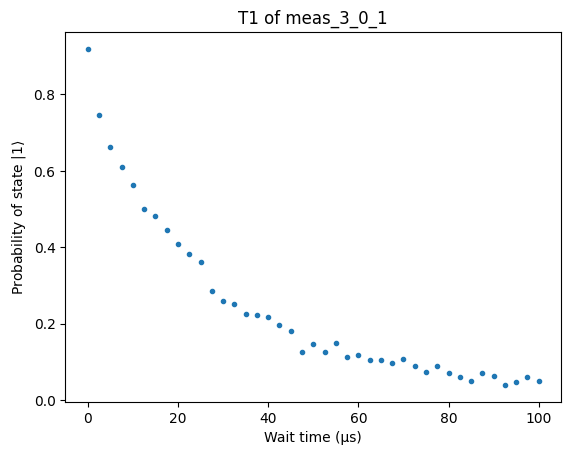

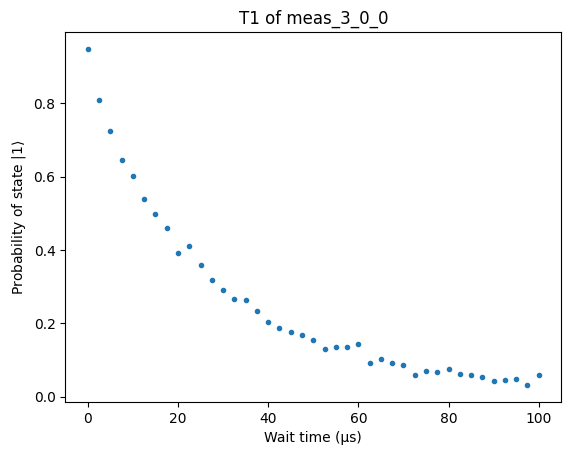

In [10]:
import matplotlib.pyplot as plt

channels = res.result[0].keys()

for channel in channels:
    plt.plot(sweep_times * 1e6, res.result[0][channel], ".")
    plt.title(f"T1 of {channel}")
    plt.xlabel("Wait time (µs)")
    plt.ylabel(r"Probability of state $|1\rangle$")
    plt.show()

We can also visualise the finalised schedule. We should see that each `segment` is different and the waits at the end are increasing towards the end.

`TIP`: If the X gates are hard to distinguish from the visualiser you can set a value for the `Instruction duration threshold`. By setting it to e.g. `1000` you squeeze/truncate all instructions that have a length over 1000 ns to a constant length within the visualiser. By clicking on the waits you can still inspect the absolute duration of the `Wait` instructions.

In [11]:
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from IPython.core.display import HTML

HTML(inspect_playlist(playlist, range(5)))